In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Impostiamo un seed per la riproducibilità
np.random.seed(42)

df = pd.read_csv('ordini_cleaned.csv')
df['Data_mat'] = pd.to_datetime(df['Data_mat'])
df = df.drop(['Data_ricarica','Unnamed: 0.1','Unnamed: 0','C_CLI','Nominativo'],axis = 1)

C:\Users\antonio.proietti\AppData\Local\Temp\ipykernel_13024\323874337.py:11: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ordini_cleaned.csv')


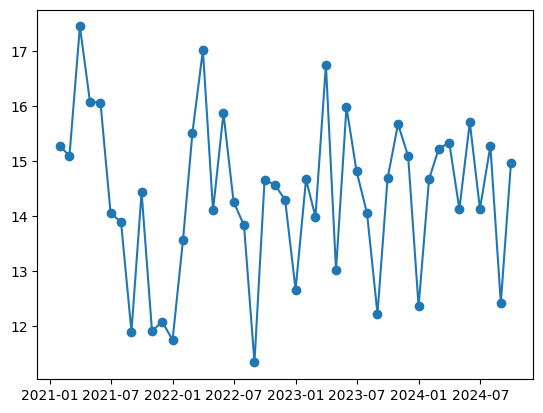

In [27]:
df_grouped = df.groupby('Data_mat').mean('Qt').reset_index()
plt.plot(df_grouped['Data_mat'],df_grouped['Qt'],marker = 'o')
plt.xlabel = 'Periodo'
plt.ylabel = 'media quantità'
plt.show()


In [28]:
df  = df.reset_index()

In [29]:
Q1 = df['Qt'].quantile(0.25)
Q3 = df['Qt'].quantile(0.75)
IQR = Q3 - Q1

clip_low = Q1 - 1.5 * IQR
clip_high = Q3 + 1.5 * IQR

In [30]:
print(f'Low boundary is {clip_low}\n high boundary is {clip_high}')

Low boundary is -10.0
 high boundary is 38.0


In [31]:
df['Qt'] = df['Qt'].apply(lambda x: 35 if x > 35 else x)
df['Qt'] = df['Qt'].apply(lambda x: 0 if x < 0 else x)

In [32]:
df = df.loc[df['Qt'] != 0]

In [33]:
df['Qt'] = np.sqrt(df['Qt'])

In [34]:
df['Qt_lag1'] = df['Qt'].shift(1)
df['Media_Mobile'] = df['Qt'].rolling(window=3).mean()

# Rimuovi le righe con valori NaN
df.dropna(inplace=True)

In [35]:
col_names = ['Azieda', 'SEDE_DI_LAVORO','CID','Valore']
for i in col_names:
    df[i] = df[i].astype(str)

<Figure size 1200x600 with 0 Axes>

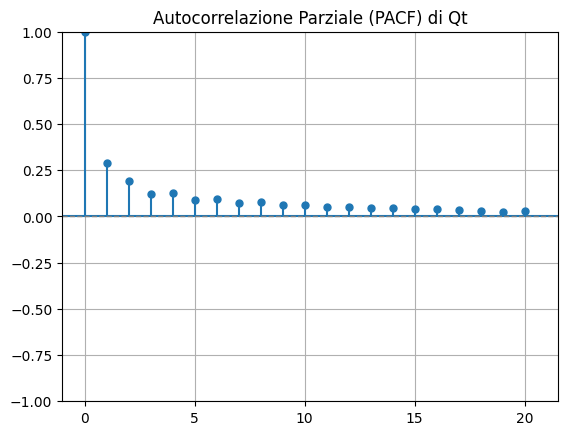

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf


plt.figure(figsize=(12, 6))
plot_pacf(df['Qt'], lags=20, alpha=0.05)
plt.title('Autocorrelazione Parziale (PACF) di Qt')

plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.grid()
plt.show()


In [37]:
df.columns

Index(['index', 'Azieda', 'CID', 'Qt', 'Valore', 'Data_mat', 'SEDE_DI_LAVORO',
       'Qt_lag1', 'Media_Mobile'],
      dtype='object')

In [38]:
df['month'] = pd.DatetimeIndex(df['Data_mat']).month

In [39]:
col_names.append('month')

In [40]:
# Aggregazione dei dati per mese
df.set_index('Data_mat', inplace=True)


In [41]:
df.head()

,index,Azieda,CID,Qt,Valore,SEDE_DI_LAVORO,Qt_lag1,Media_Mobile,month
Data_mat,,,,,,,,,
2023-10-31,2,A2A AIRPORT ENERGY SPA,64801,4.123106,900,MALPENSA - AEROPORTO,4.358899,4.318047,10
2023-10-31,3,A2A AIRPORT ENERGY SPA,64802,1.000000,700,MALPENSA - AEROPORTO,4.123106,3.160668,10
2023-10-31,4,A2A AIRPORT ENERGY SPA,64802,4.242641,900,MALPENSA - AEROPORTO,1.000000,3.121915,10
2023-10-31,5,A2A AIRPORT ENERGY SPA,64803,4.582576,900,MALPENSA - AEROPORTO,4.242641,3.275072,10
2023-10-31,6,A2A AIRPORT ENERGY SPA,64804,4.472136,900,MALPENSA - AEROPORTO,4.582576,4.432451,10


In [42]:
df = df.sort_index(ascending = True)

In [43]:
# Suddivisione in set di addestramento e di test
split_point = int(len(df)*0.8)
train = df[:split_point]
test = df[split_point:]

In [44]:
y_train = train['Qt']
y_test = test['Qt']

In [45]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols = col_names)
# Creiamo un DataFrame con le variabili codificate
train_encoded = encoder.fit_transform(train[col_names], train['Qt'])

test_encoded = encoder.transform(test[col_names])
# Visualizza il DataFrame codificato
print(train_encoded.head())

              Azieda  SEDE_DI_LAVORO       CID    Valore     month
Data_mat                                                          
2021-01-31  4.278499        3.627121  4.376300  4.122405  3.644862
2021-01-31  3.799636        3.526186  2.697696  4.122405  3.644862
2021-01-31  3.799636        3.526186  2.697696  3.440946  3.644862
2021-01-31  3.799636        3.145553  2.548932  4.122405  3.644862
2021-01-31  3.799636        3.145553  2.353546  4.122405  3.644862


In [46]:
train_encoded['Qt'] = y_train.values
test_encoded['Qt'] = y_test.values

In [47]:
train_encoded.head()

,Azieda,SEDE_DI_LAVORO,CID,Valore,month,Qt
Data_mat,,,,,,
2021-01-31,4.278499,3.627121,4.376300,4.122405,3.644862,5.000000
2021-01-31,3.799636,3.526186,2.697696,4.122405,3.644862,1.000000
2021-01-31,3.799636,3.526186,2.697696,3.440946,3.644862,4.242641
2021-01-31,3.799636,3.145553,2.548932,4.122405,3.644862,4.358899
2021-01-31,3.799636,3.145553,2.353546,4.122405,3.644862,4.123106


In [48]:
qt_columns = ['Qt_lag1',#'Qt_lag2','Qt_lag3',
'Media_Mobile']

In [51]:
import xgboost as xgb

# Separazione delle variabili indipendenti dalla variabile target
X_train = train_encoded.drop(columns=['Qt'])
X_test = test_encoded.drop(columns=['Qt'])
for i in qt_columns:
    X_train[i] = train[i]
    X_test [i] = test[i]
y_train = train_encoded['Qt']
y_test = test_encoded['Qt']


In [52]:

# Creazione del DMatrix per XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Impostazione dei parametri del modello
params = {
    'objective': 'reg:squarederror',  # Obiettivo di regressione per MAE
    'max_depth': 6,                        # Profondità massima degli alberi
    'learning_rate': 0.1,                  # Tasso di apprendimento
    'n_estimators': 100,                   # Numero di alberi
    'seed': 42
}


In [53]:

# Allenamento del modello
model = xgb.train(params, dtrain, num_boost_round=100)

# Previsione
predictions = model.predict(dtest)

# Calcolo delle metriche di performance
mae = mean_absolute_error(y_test, predictions)

print(f'MAE: {mae:.2f}')

c:\Users\antonio.proietti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


MAE: 0.41


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Previsioni del modello XGBoost
xgb_predictions = model.predict(dtest)  # Assicurati di avere il tuo X_test correttamente definito

# Calcolo delle metriche
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print(f'XGBoost RMSE: {xgb_rmse:.2f}')
print(f'XGBoost MAE: {xgb_mae:.2f}')


XGBoost RMSE: 0.59
XGBoost MAE: 0.41


In [56]:
new_data = {
    'Data_mat': ['2024-10-31'],
    'Azieda': ['A2A ENERGY SOLUTIONS SRL'], 
    'CID': 46859, 
    'month': 10,
    'Valore':1340, 
    'SEDE_DI_LAVORO': ['CARACCIOLO'], 
    'Qt_lag1':[np.sqrt(df[df.index == '2024-09-30']['Qt'].mean())],
    'Media_Mobile': [np.sqrt(df[df.index >= '2024-07-31']['Qt'].mean())]
}

new_observation = pd.DataFrame(new_data)
new_observation.set_index('Data_mat', inplace=True)

new_observation_encoded = encoder.transform(new_observation[col_names])

merged_new_observation = new_observation_encoded
for i in qt_columns:
    merged_new_observation[i] = new_observation[i]
    
d_observation = xgb.DMatrix(new_observation_encoded)
result = model.predict(d_observation)[0]
print(f'next month tickets: {result**2:.0f}')

next month tickets: 5


In [ ]:
len(train_encoded)

476721

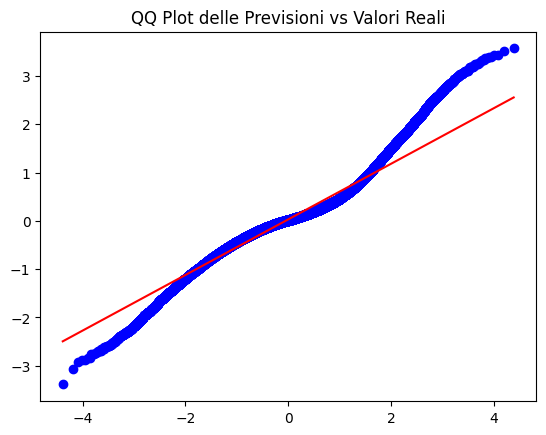

In [63]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calcola i quantili dei valori predetti e dei valori reali
xgb_predictions = pd.DataFrame(xgb_predictions)
xgb_predictions.columns = ['Qt']
xgb_predictions = xgb_predictions['Qt'].apply(lambda x: 0 if x < 1 else x)
stats.probplot(xgb_predictions - test_encoded['Qt'].values, dist="norm", plot=plt)

# Titolo e etichette
plt.title("QQ Plot delle Previsioni vs Valori Reali")


# Mostra il plot
plt.show()


- Provare ad aggiungere altre informazioni (es: qualifica, percentuale part time, etc)
- Provare ad aggiungere altri lag valutando l'ordine tramite BIC o AIC
- Provare a valutare l'impatto dell'aggiunta di alcune società (come break)

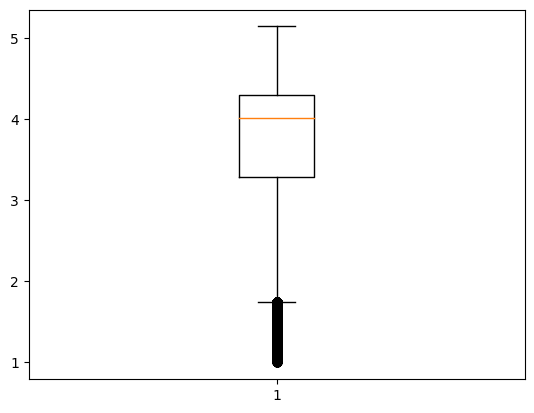

In [ ]:
plt.boxplot(xgb_predictions)
plt.show()

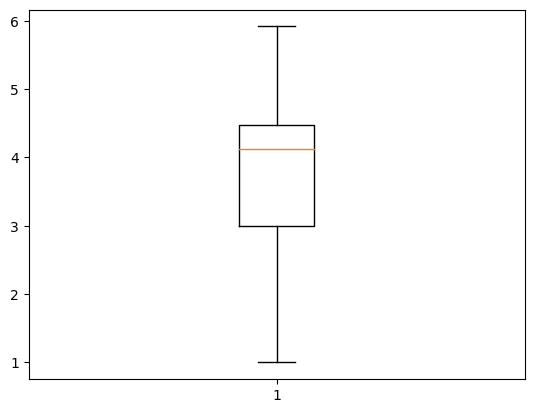

In [ ]:
plt.boxplot(test_encoded['Qt'])
plt.show()